In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.ticker as plticker
import plotly.express as px
import pandas as pd
import numpy as np
from pandasql import sqldf
from datetime import datetime
import requests
import rdflib
import os
import gzip

In [2]:
df_import = pd.read_csv("data/smwsTotal_3.csv")

Reduce dataset to features used in analysis

In [3]:
df = df_import[['Unnamed: 0', 'Has URL', 'Has article count', 'Has users count', 'Has edit count', 'Has property count', 'Has location']]
df.columns = ['Name', 'Has URL', 'Pages', 'Users', 'Edits', 'Triples', 'Coordinates']

df_edit = df_import[['Modification date']]
df_created = df_import[['Creation date']]

df['Avg_Edits'] = (df['Edits'] / df['Pages'])
df = df.replace([np.inf, -np.inf], np.nan).dropna()


/var/folders/bf/p2txs1pj5h52q3k7m0xdtrcc0000gp/T/ipykernel_32221/404013803.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Avg_Edits'] = (df['Edits'] / df['Pages'])


Strip dates for better calculations

In [4]:
df_edit = df_edit.dropna()
df_created = df_created.dropna()

def split(row):

    s = ''
    s = s + row[0].split(' ', 1)[1]
    s = s.split(' ', 2)[0] + ' ' + s.split(' ', 2)[1]
    
    return s

df_edit['mod_date'] = df_edit.apply(split, axis = 1)
df_created['created'] = df_created.apply(split, axis = 1)

Count occurences per month

In [5]:
#df_edit.groupby(pd.to_datetime(df_edit['Modification date']).dt.strftime('%b-%Y'), sort=False)['Rep'].size().plot()

df_test = df_edit.groupby(df_edit['mod_date'], as_index=False).count()
df_show = df_created.groupby(df_created['created'], as_index=False).count()

df_test.columns = ['mod_date', 'count']
df_show.columns = ['created_date', 'count']

print(df_show)

df_test['index'] = pd.to_datetime(df_test['mod_date'], format='%B %Y')
df_show['index'] = pd.to_datetime(df_show['created_date'], format='%B %Y')


df_test = df_test.sort_values('index')
df_show = df_show.sort_values('index')

df_show = df_show.iloc[-63:]

df_show

       created_date  count
0        April 2013     11
1        April 2014     15
2        April 2015      3
3        April 2016      8
4        April 2017      3
..              ...    ...
100  September 2017      4
101  September 2018     13
102  September 2019      2
103  September 2020     20
104  September 2021     10

[105 rows x 2 columns]


,created_date,count,index
13,August 2016,3,2016-08-01
99,September 2016,4,2016-09-01
90,October 2016,1,2016-10-01
82,November 2016,3,2016-11-01
22,December 2016,1,2016-12-01
...,...,...,...
27,December 2021,14,2021-12-01
36,February 2022,22,2022-02-01
68,March 2022,3,2022-03-01
9,April 2022,2,2022-04-01


Find biggest SMWs

In [8]:
q = "SELECT Name, Triples, Pages, Triples/Pages FROM df order by Triples desc LIMIT 20"
sqldf(q, globals())

,Name,Triples,Pages,Triples/Pages
0,Kanterella,106332072.0,557798.0,190.628278
1,Sanat,36608932.0,1055799.0,34.674149
2,Wien Geschichte Wiki,27205438.0,326044.0,83.441002
3,Familypedia,20181953.0,289734.0,69.656834
4,Traditio,20018857.0,44231.0,452.597884
5,The Third Turn,19300397.0,2327003.0,8.294101
6,Liquipedia Counter-Strike,16587259.0,188753.0,87.878121
7,Guild Wars 2 Wiki (en),11512264.0,95910.0,120.031947
8,Järviwiki,10603581.0,97932.0,108.274936
9,Yu-Gi-Oh! Wikia,9682514.0,125123.0,77.383966


Convert coordinates to plot on world map

In [9]:
def dms_to_decimal(cor):
    s = ""

    s = s + cor.split('°')[0]
    cor = cor.split('°')[1].replace(' ', '')
    
    s = float(s) + int((cor.split('\'')[0]))/60
    cor = cor.split('\'')[1].replace(' ', '')

    s = float(s) + int(cor.replace('\"', ''))/3600

    return float("{0:.5f}".format(s))

test = "43° 25' 58\""

#print(dms_to_decimal(test))

Convert coordinates in df

In [11]:
df['Coordinates'] = df['Coordinates'].astype(str)
df[["Latitude", "Longitude"]] = df["Coordinates"].str.split(",", expand=True)
#longitude_decimal = [dms_to_decimal(x) for x in df['Longitude']]
#latitude_decimal = [dms_to_decimal(x) for x in df['Latitude']]

df['lat'] = [dms_to_decimal(x) for x in df['Latitude']]
df['long'] = [dms_to_decimal(x) for x in df['Longitude']]

Create world map to see hosting locations of SMW instances

In [19]:
fig = px.scatter_geo(df,lat='lat',lon='long', hover_name='Name')#, width=3000, height=1200)
#fig.update_layout(title_x=0.5)
fig.update_traces(marker=dict(size=10))
fig.show()
fig.write_image("Images/world_map.png")

Plot the average number of edits per SMW instance

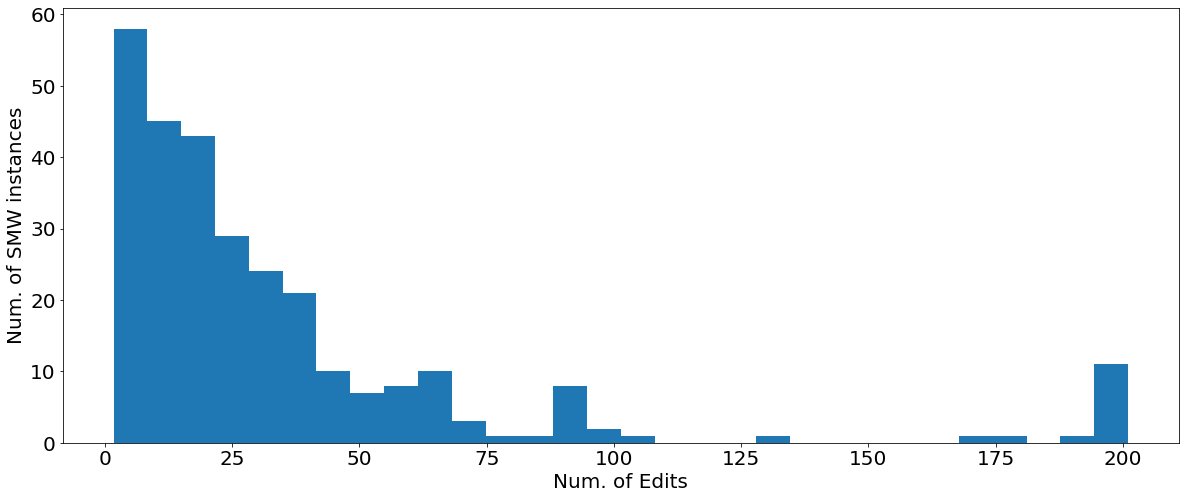

In [15]:
edits = df['Avg_Edits'].tolist()

edits = np.array(edits)

plt.figure(figsize=(20, 8))
plt.hist(edits, bins=30)

#plt.bar(triples, width=0.3)
plt.xlabel('Num. of Edits')
plt.ylabel('Num. of SMW instances')
plt.ticklabel_format(axis = 'both', style = 'plain')
plt.rcParams.update({'font.size': 20})
plt.show()

Plot the number of triples per SMW instance

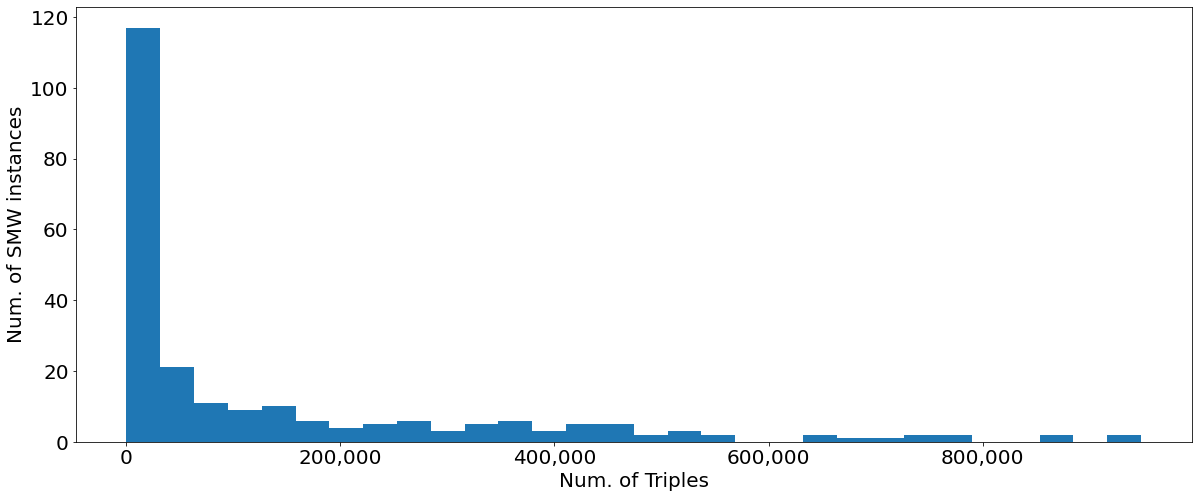

In [16]:
def xfunc(x, pos):
    s = '{:0,d}'.format(int(x))
    return s

list = []

for i in df['Triples'].tolist():
    if i > 0:
        list.append(i)

triples = np.array(list)

x_format = tkr.FuncFormatter(xfunc)


fig, ax = plt.subplots()
fig.set_size_inches(20,8)
ax.hist(triples, bins = 30)
ax.xaxis.set_major_formatter(x_format)
ax.set_xlabel('Num. of Triples')
ax.set_ylabel('Num. of SMW instances')

plt.show()

SMW topics

In [ ]:
tag_df = df_import[["Has URL", "Has tag"]]

tag_df = tag_df.dropna() 

tag_list = tag_df["Tag"].tolist()

tag_dict = {}

for i in tag_list:
    if i in tag_dict:
        tag_dict[i] = tag_dict[i] + 1
    else:
        tag_dict[i] = 1

#get 10 biggest categories
tag_nums = list(tag_dict.values())

list.sort(tag_nums, reverse = True)

Find the categories with the most occurences

In [ ]:
tag_keys = list(tag_dict.keys())

sum_tags = sum(tag_nums)

for i in tag_keys:
    if tag_dict[i] < 8:
        del tag_dict[i]
        #print (tag_dict[i])
    else:
        tag_dict[i] = (tag_dict[i] / sum_tags) * 100

tag_dict = dict(sorted(tag_dict.items(), key=lambda item: item[1], reverse=True))

Plot the topics with the highest number of occurences

In [ ]:
lists = tag_dict.items()

x, y = zip(*lists) 

fig, ax = plt.subplots()
fig.set_size_inches(20,8)
bars = ax.bar(x, y, width=0.31)
ax.set_xlabel('Topic')
ax.set_ylabel('Number of Occurences in %')

ax.bar_label(bars, labels = bar_labels)

plt.rcParams.update({'font.size': 20})
plt.legend(['Topics in %'])
plt.show()

error statistics

In [ ]:
path = "errors.json"

df = pd.read_json(path)
df = df.T

df = df.drop([1,2], axis = 1)

df['index_col'] = df.index

df = df.reset_index()
df.columns = ["wiki", "error", "wiki2"]

df = df[["wiki", "error"]]

In [ ]:
df_plot = df.groupby(df["error"], as_index=False).count()

df_plot.iloc[0,0] = "429 Limited access rate"
df_plot.iloc[0,1] = 0
df_plot.iloc[2,0] = "Check for secure connection"

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(20,8)
ax.bar(df_plot['error'], df_plot['wiki'], width=0.4)
ax.set_xlabel('Name of the error')
ax.set_ylabel('Number of occurences')

plt.rcParams.update({'font.size': 20})
plt.show()

RDF predicates

In [ ]:
#path to local rdf directory
rootdir = ''
unique_predicates = []

idx = 0

for subdir, dirs, files in os.walk(rootdir):
   # Set up an RDF graph to store the data
   g = rdflib.Graph()

   idx += 1

   # Load the RDF files into the graph
   for file in files:
      try:
         g.parse(os.path.join(subdir, file))
      except:
         break
      
   # Create a set to store the predicates
   predicates = set()

   # Iterate over the triples in the graph
   for s, p, o in g:
      # Add the predicate to the set
      predicates.add(p)

   # Print the number of distinct predicates
   print(str(idx), str(len(predicates)))
   unique_predicates.append(len(predicates))

Boxplot of the number of unique RDF predicates

In [ ]:
unique_predicates = [i for i in unique_predicates if i != 0]

data = np.asarray(unique_predicates)

fig = plt.figure(figsize =(20, 4))
 
plt.boxplot(data, vert=False, widths=0.5)

plt.show()

SMW frequent maintainance

In [ ]:
df_import = pd.read_csv("data/smwsTotal_3.csv")

df = df_import[['Unnamed: 0', 'Founded date', 'Has edit count', 'Modification date']]

In [ ]:
def getDaysExistence(date):
    day = ''

    if len(date.split(' ', 3)) >= 3:
        day = date.split(' ', 3)[0] + " " + date.split(' ', 3)[1] + " " + date.split(' ', 3)[2]
    else:
        return 0

    date = datetime.strptime(day, "%d %B %Y")
    #26.10.2022 is set as the reference date for the calculation
    dateToday = datetime.strptime("26 October 2022", "%d %B %Y")
    delta = dateToday - date

    return delta.days


In [ ]:
df['Days of existence'] = df['Founded date'].apply(getDaysExistence)        
df['Days since last edit'] = df['Modification date'].apply(getDaysExistence) 

df['Days not maintained'] = df['Days of existence'] - df['Days since last edit']

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(20,8)
ax.scatter(df['Days of existence'], df['Days since last edit'])
ax.set_xlabel('Days of existense')
ax.set_ylabel('Days since last edit')

plt.rcParams.update({'font.size': 20})

plt.show()

In [ ]:
df.where(df['Days since last edit'] < 365).dropna()

In [ ]:
df.where(df['Days since last edit'] > 1500).dropna()

In [ ]:
df.loc[(df['Days since last edit'] > 2000)  & df['Days of existence'] < 3000]